In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import json

# TensorFlow >= 2.0 is required
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
assert tf.__version__ >= "2.0"

C:\Users\PHO\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Path to Dataset

In [ ]:
# folder parameters
set = 'ISOL'
instrument = 'AkPnBsdf'
playing_style = 'ISOL'

In [2]:
datasettoppath = os.path.join(os.getcwd(),'data','MAPS')
datasettoppath

dataset_prefix = ['ref','snp','tar']

train_ref_pth = os.path.join(datasettoppath,'train_ref_'+instrument+'_'+set+'_'+playing_style+'.npy')
train_snp_pth = os.path.join(datasettoppath,'train_snp_'+instrument+'_'+set+'_'+playing_style+'.npy')
train_tar_pth = os.path.join(datasettoppath,'train_tar_'+instrument+'_'+set+'_'+playing_style+'.npy')
test_ref_pth = os.path.join(datasettoppath,'test_ref_'+instrument+'_'+set+'_'+playing_style+'.npy')
test_snp_pth = os.path.join(datasettoppath,'test_snp_'+instrument+'_'+set+'_'+playing_style+'.npy')
test_tar_pth = os.path.join(datasettoppath,'test_tar_'+instrument+'_'+set+'_'+playing_style+'.npy')

train_ref_pth

'h:\\DL4AD\\Score following\\dl4ad-group5\\data\\MAPS\\train_ref_AkPnBsdf_ISOL_ISOL.npy'

## Read training and test data from disk

In [ ]:
# del train_ref
# del train_snp
# del train_tar

# del test_ref 
# del test_snp 
# del test_tar 

In [5]:
# read back saved dataset
train_ref = np.load(train_ref_pth, mmap_mode='r')
train_tar = np.load(train_tar_pth, mmap_mode='r')
train_snp = np.load(train_snp_pth, mmap_mode='r')

test_ref = np.load(test_ref_pth, mmap_mode='r')
test_snp = np.load(test_snp_pth, mmap_mode='r')
test_tar = np.load(test_tar_pth, mmap_mode='r')

## Create/Set checkpoint location 

In [3]:
from IPython import get_ipython
ip = get_ipython()
notebookpath = None
if '__vsc_ipynb_file__' in ip.user_ns:
    notebookpath = ip.user_ns['__vsc_ipynb_file__']

notebookfilename = Path(notebookpath).stem
model_dir = os.path.join('_models',notebookfilename)
# make _models directory if not exists
os.makedirs(model_dir, exist_ok=True)
model_dir

'_models\\train_test_00_02_AkPnBsdf_ISOL'

## Read configuration file

In [4]:
with open(os.path.join(datasettoppath,'MAPS_config.json'), 'r') as f:
    config = json.load(f)

print(json.dumps(config, indent=4))

{
    "audio_length": 12,
    "audio_length_smp": 529200,
    "classes": [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28,
        29,
        30,
        31,
        32,
        33,
        34,
        35,
        36,
        37,
        38,
        39,
        40,
        41,
        42,
        43,
        44,
        45,
        46,
        47,
        48,
        49,
        50,
        51,
        52,
        53,
        54,
        55,
        56,
        57,
        58,
        59,
        60,
        61,
        62,
        63,
        64,
        65,
        66,
        67,
        68,
        69,
        70,
        71,
        72,
        73,
        74,
        75,
        76,
        77,

## Set up Neural Net

In [ ]:
# decide to start from scratch or to load a checkpoint
load_last_checkpoint = False 

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Specify GPU ID
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Allow TensorFlow to allocate memory on all available GPUs
strategy = tf.distribute.MirroredStrategy()
# this does not show any intel... seems a jupyter notebook problem... at least when you run it in visual studio code
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [7]:
def build_reduced_model_01(input_shape_ref, input_shape_snp, n_classes):
    # Sheet
    sheet_input = tf.keras.Input(shape=input_shape_ref, name='sheet_input')
    sheet_model = layers.Conv2D(16, (3, 3), padding='same')(sheet_input)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.MaxPooling2D((2, 2), padding='same')(sheet_model)
    sheet_model = layers.Flatten()(sheet_model)


    # Spectro
    spectro_input = tf.keras.Input(shape=input_shape_snp, name='spectro_input')
    spectro_model = layers.Conv2D(16, (3, 3), padding='same')(spectro_input)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.MaxPooling2D((2, 2), padding='same')(spectro_model)
    spectro_model = layers.Flatten()(spectro_model)

    # Concatenating
    combined_input = layers.concatenate([sheet_model, spectro_model])

    final = layers.Dense(256)(combined_input)
    final = layers.BatchNormalization()(final)
    final = layers.Activation('relu')(final)
    final = layers.Dropout(0.3)(final)

    output = layers.Dense(n_classes, activation='softmax')(final)

    model = tf.keras.Model(inputs=[sheet_input, spectro_input], outputs=output)

    return model

def build_reduced_model_02(input_shape_ref, input_shape_snp, n_classes):
    # Sheet
    sheet_input = tf.keras.Input(shape=input_shape_ref, name='sheet_input')
    sheet_model = layers.Conv2D(32, (3, 3), padding='same')(sheet_input)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.Conv2D(64, (3, 3), padding='same')(sheet_model)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.MaxPooling2D((2, 2), padding='same')(sheet_model)
    sheet_model = layers.Dropout(0.3)(sheet_model)

    sheet_model = layers.Conv2D(128, (3, 3), padding='same')(sheet_model)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.MaxPooling2D((2, 2), padding='same')(sheet_model)
    sheet_model = layers.Dropout(0.3)(sheet_model)

    sheet_model = layers.Flatten()(sheet_model)

    # Spectro
    spectro_input = tf.keras.Input(shape=input_shape_snp, name='spectro_input')
    spectro_model = layers.Conv2D(32, (3, 3), padding='same')(spectro_input)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.Conv2D(64, (3, 3), padding='same')(spectro_model)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.MaxPooling2D((2, 2), padding='same')(spectro_model)
    spectro_model = layers.Dropout(0.3)(spectro_model)

    spectro_model = layers.Conv2D(128, (3, 3), padding='same')(spectro_model)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.MaxPooling2D((2, 2), padding='same')(spectro_model)
    spectro_model = layers.Dropout(0.3)(spectro_model)

    spectro_model = layers.Flatten()(spectro_model)

    # Concatenating
    combined_input = layers.concatenate([sheet_model, spectro_model])

    final = layers.Dense(512)(combined_input)
    final = layers.BatchNormalization()(final)
    final = layers.Activation('relu')(final)
    final = layers.Dropout(0.3)(final)

    final = layers.Dense(512)(final)
    final = layers.BatchNormalization()(final)
    final = layers.Activation('relu')(final)
    final = layers.Dropout(0.3)(final)

    output = layers.Dense(n_classes, activation='softmax')(final)

    model = tf.keras.Model(inputs=[sheet_input, spectro_input], outputs=output)

    return model

def build_model_Dorfer(input_shape_ref, input_shape_snp, n_classes):
    # Sheet
    sheet_input = tf.keras.Input(shape=input_shape_ref, name='sheet_input')
    sheet_model = layers.Conv2D(32, 
                            kernel_size=(5, 5), 
                            strides=(1, 1),  # Stride of 1
                            dilation_rate=(2, 2),  # Dilation rate of 2
                            padding='same')(sheet_input)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.Conv2D(64, (3, 3), padding='same')(sheet_model)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.MaxPooling2D((2, 2), padding='same')(sheet_model)
    sheet_model = layers.Dropout(0.15)(sheet_model)

    sheet_model = layers.Conv2D(128, (3, 3), padding='same')(sheet_model)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.Conv2D(128, (3, 3), padding='same')(sheet_model)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)

    sheet_model = layers.MaxPooling2D((2, 2), padding='same')(sheet_model)
    sheet_model = layers.Dropout(0.15)(sheet_model)

    sheet_model = layers.Flatten()(sheet_model)

    sheet_model = layers.Dense(1024)(sheet_model)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)
    sheet_model = layers.Dropout(0.3)(sheet_model)

    # Spectro
    spectro_input = tf.keras.Input(shape=input_shape_snp, name='spectro_input')
    spectro_model = layers.Conv2D(64, (3, 3), padding='same')(spectro_input)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.Conv2D(64, (3, 3), padding='same')(spectro_model)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.MaxPooling2D((2, 2), padding='same')(spectro_model)
    spectro_model = layers.Dropout(0.15)(spectro_model)

    spectro_model = layers.Conv2D(96, (3, 3), padding='same')(spectro_model)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.MaxPooling2D((2, 2), padding='same')(spectro_model)
    spectro_model = layers.Dropout(0.15)(spectro_model)

    spectro_model = layers.Conv2D(96, (3, 3), padding='same')(spectro_model)
    spectro_model = layers.BatchNormalization()(spectro_model)
    spectro_model = layers.Activation('relu')(spectro_model)

    spectro_model = layers.MaxPooling2D((2, 2), padding='same')(spectro_model)
    spectro_model = layers.Dropout(0.15)(spectro_model)

    spectro_model = layers.Flatten()(spectro_model)

    sheet_model = layers.Dense(1024)(sheet_model)
    sheet_model = layers.BatchNormalization()(sheet_model)
    sheet_model = layers.Activation('relu')(sheet_model)
    sheet_model = layers.Dropout(0.3)(sheet_model)

    # Concatenating
    combined_input = layers.concatenate([sheet_model, spectro_model])

    final = layers.Dense(1024)(combined_input)
    final = layers.BatchNormalization()(final)
    final = layers.Activation('relu')(final)
    final = layers.Dropout(0.3)(final)

    final = layers.Dense(1024)(final)
    final = layers.BatchNormalization()(final)
    final = layers.Activation('relu')(final)
    final = layers.Dropout(0.3)(final)

    output = layers.Dense(n_classes, activation='softmax')(final)

    model = tf.keras.Model(inputs=[sheet_input, spectro_input], outputs=output)

    return model

## Choose model

In [9]:
# COMPILE MODEL
metrics = 'accuracy'

if load_last_checkpoint:
    checkpoint_folder = os.path.join(os.getcwd(),model_dir)
    checkpoint_files = glob.glob(os.path.join(checkpoint_folder, '*.h5'))
    latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
    model = tf.keras.models.load_model(latest_checkpoint)
else:
    # get model
    #model = build_reduced_model_01(input_shape_ref=config['input_shape_ref'], input_shape_snp=config['input_shape_snp'], n_classes=config['n_frames'])
    #model = build_reduced_model_02(input_shape_ref=config['input_shape_ref'], input_shape_snp=config['input_shape_snp'], n_classes=config['n_frames'])
    model = build_model_Dorfer(input_shape_ref=config['input_shape_ref'], input_shape_snp=config['input_shape_snp'], n_classes=config['n_frames'])

# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sheet_input (InputLayer)       [(None, 1, 102, 120  0           []                               
                                0)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 1, 102, 32)   960032      ['sheet_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 1, 102, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# set checkpoint callback
filepath_cb = model_dir+"/chckpnt-{epoch:02d}-{loss:.2f}.h5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath_cb, 
                                                   monitor='loss', 
                                                   verbose=0, 
                                                   save_best_only=True,
                                                   save_weights_only=False, 
                                                   mode='auto', 
                                                   save_freq='epoch')

# early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                     min_delta=0, 
                                                     patience=20, 
                                                     verbose=0, 
                                                     mode='auto', 
                                                     baseline=None, 
                                                     restore_best_weights=True)

reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

## Just run once to accumulate history

In [12]:
total_epochs = 0

history_dict = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

## Set number of epochs and batch size

In [30]:
# fit model
n_epochs = 100
batch_size = 3

train_tar_reshaped = np.squeeze(train_tar, axis=1)
test_tar_reshaped = np.squeeze(test_tar, axis=1)

# Set the device
use_gpu = True
gpus = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

if gpus and use_gpu:
    print("Using GPU.")
    with tf.device('GPU:0'):
        history = model.fit([train_ref,train_snp],
                    train_tar_reshaped, 
                    validation_data=([test_ref,test_snp], test_tar_reshaped),
                    epochs=n_epochs,
                    #initial_epoch=total_epochs+1,
                    batch_size=batch_size,
                    callbacks=[checkpoint_cb, early_stopping_cb,reduce_lr_cb])
else:
    print("Using CPU.")
    with tf.device('CPU:0'):
        history = model.fit([train_ref,train_snp],
                    train_tar_reshaped, 
                    validation_data=([test_ref,test_snp], test_tar_reshaped),
                    epochs=n_epochs,
                    #initial_epoch=total_epochs+1,
                    batch_size=batch_size,
                    callbacks=[checkpoint_cb, early_stopping_cb,reduce_lr_cb])

#use initial_epoch=0 in model.fit if you would like to force starting over
        
for key in history_dict.keys():
     history_dict[key].extend(history.history[key])
total_epochs += n_epochs


Using GPU.
Epoch 1/100
827/827 [==============================] - 16s 20ms/step - loss: 1.0095 - accuracy: 0.7763 - val_loss: 1.5523 - val_accuracy: 0.6457 - lr: 0.0010
Epoch 2/100
827/827 [==============================] - 16s 19ms/step - loss: 1.0217 - accuracy: 0.7662 - val_loss: 1.4728 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 3/100
827/827 [==============================] - 16s 19ms/step - loss: 0.9942 - accuracy: 0.7791 - val_loss: 1.6186 - val_accuracy: 0.6634 - lr: 0.0010
Epoch 4/100
827/827 [==============================] - 16s 19ms/step - loss: 1.0317 - accuracy: 0.7678 - val_loss: 1.4894 - val_accuracy: 0.6747 - lr: 0.0010
Epoch 5/100
827/827 [==============================] - 16s 19ms/step - loss: 0.9862 - accuracy: 0.7715 - val_loss: 1.4176 - val_accuracy: 0.6795 - lr: 0.0010
Epoch 6/100
827/827 [==============================] - 16s 19ms/step - loss: 0.9766 - accuracy: 0.7799 - val_loss: 1.5364 - val_accuracy: 0.6924 - lr: 0.0010
Epoch 7/100
827/827 [====================

## Plot loss and accuracy

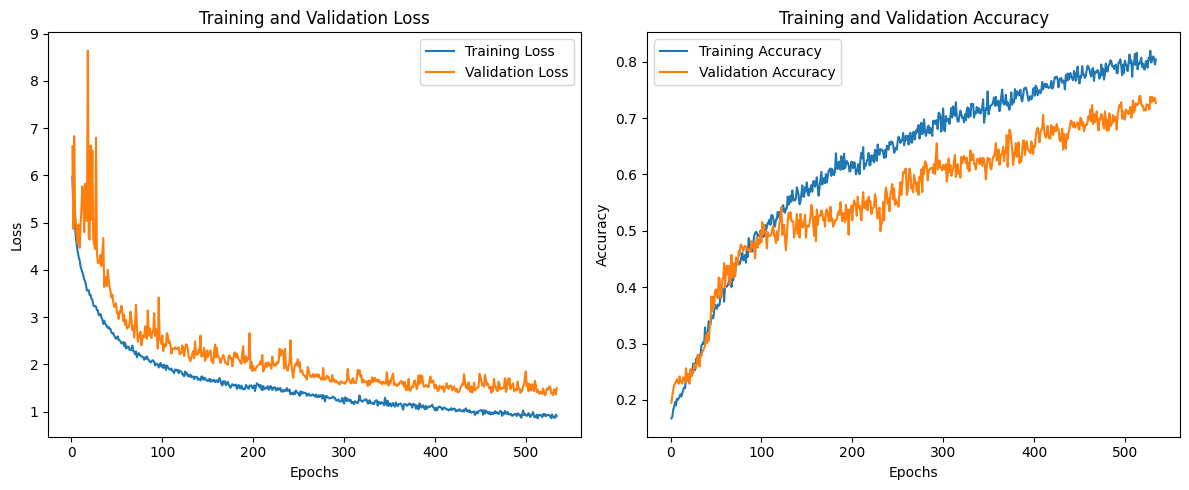

Total epochs= 534


In [31]:
last_epoch = len(history_dict['loss'])

import matplotlib.pyplot as plt

# Get training and validation loss values
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get training and validation accuracy values
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Plotting loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, last_epoch+1), train_loss, label='Training Loss')
plt.plot(range(1, last_epoch+1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, last_epoch+1), train_acc, label='Training Accuracy')
plt.plot(range(1, last_epoch+1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Total epochs=',last_epoch)

## Predictions and Bucket hit rates

In [150]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
predictions = model.predict([test_ref,test_snp])

# Convert predictions to classes
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(np.argmax(test_tar[:, 0], axis=1), predicted_classes)


20/20 [==============================] - 0s 15ms/step


In [180]:
# Calculate the indices of the top 2 bucket
test_tar_reshaped = np.squeeze(test_tar, axis=1)
Top_2_bucket_indices = [np.argpartition(tararr, -2)[-2:] for tararr in test_tar_reshaped] 
#Top_2_bucket_indices[0].shape

# Get the sorted indices for each array
sorted_indices = [np.argsort(predarr) for predarr in predictions]
#sorted_indices[0].shape

# Extract the last index from sorted indices
last_indices_sorted = [idxs[-1] for idxs in sorted_indices]

# Calculate the distances
distances = np.array(Top_2_bucket_indices) - np.array(last_indices_sorted)[:, np.newaxis]

# print("Top_2_bucket_indices:", Top_2_bucket_indices)
# print("Sorted indices:", sorted_indices)
# print("Top_1_bucket distance:", distances[:,1])
# print("Top_2_bucket distance:", distances[:,0])

dev_per_frame = 100/config['n_frames']
dev_t_per_frame = 1/config['n_frames']

distance_frames = dev_per_frame*distances
distance_sec = dev_t_per_frame*distances

Abs_distance_sec = np.abs(dev_t_per_frame*distances)

# print("Top_1_bucket deviation percentage:", np.round(distance_frames[:,1],4))
# print("Top_2_bucket deviation percentage:", np.round(distance_frames[:,0],4))
# print("Top_1_bucket deviation time in s:", np.round(distance_sec[:,1],4))
# print("Top_2_bucket deviation time in s:", np.round(distance_sec[:,0],4))

mean_dev_top_1 = np.round(np.mean(Abs_distance_sec[:,1]),4)
mean_dev_top_2 = np.round(np.mean(Abs_distance_sec[:,0]),4)
median_dev_top_1 = np.round(np.median(Abs_distance_sec[:,1]),4)
median_dev_top_2 = np.round(np.median(Abs_distance_sec[:,0]),4)

print('Top_1_bucket mean deviation time:',mean_dev_top_1 ,'median deviation time:',median_dev_top_1)
print('Top_2_bucket mean deviation time :',mean_dev_top_2 ,'median deviation time:',median_dev_top_2)

Top_1_bucket mean deviation time: 0.016 median deviation time: 0.0
Top_2_bucket mean deviation time : 0.0167 median deviation time: 0.0008


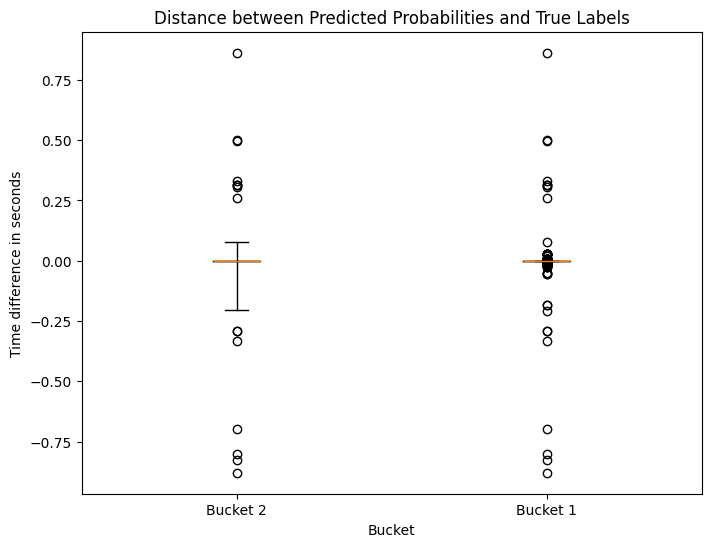

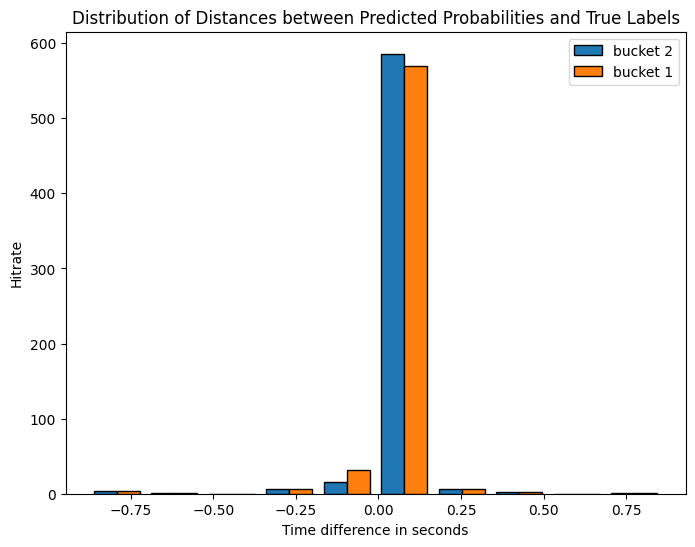

In [179]:

# Visualize the distribution of distances using a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(distance_sec, labels=['Bucket 2', 'Bucket 1'], whis=150)
plt.title('Distance between Predicted Probabilities and True Labels')
plt.ylabel('Time difference in seconds')
plt.xlabel('Bucket')
plt.show()

# Alternatively, visualize the distribution using a histogram
plt.figure(figsize=(8, 6))
plt.hist(distance_sec, bins=10, edgecolor='black')
plt.title('Distribution of Distances between Predicted Probabilities and True Labels')
plt.xlabel('Time difference in seconds')
plt.ylabel('Hitrate')
plt.legend(['bucket 2','bucket 1'])
plt.show()

## Confusion Matrix

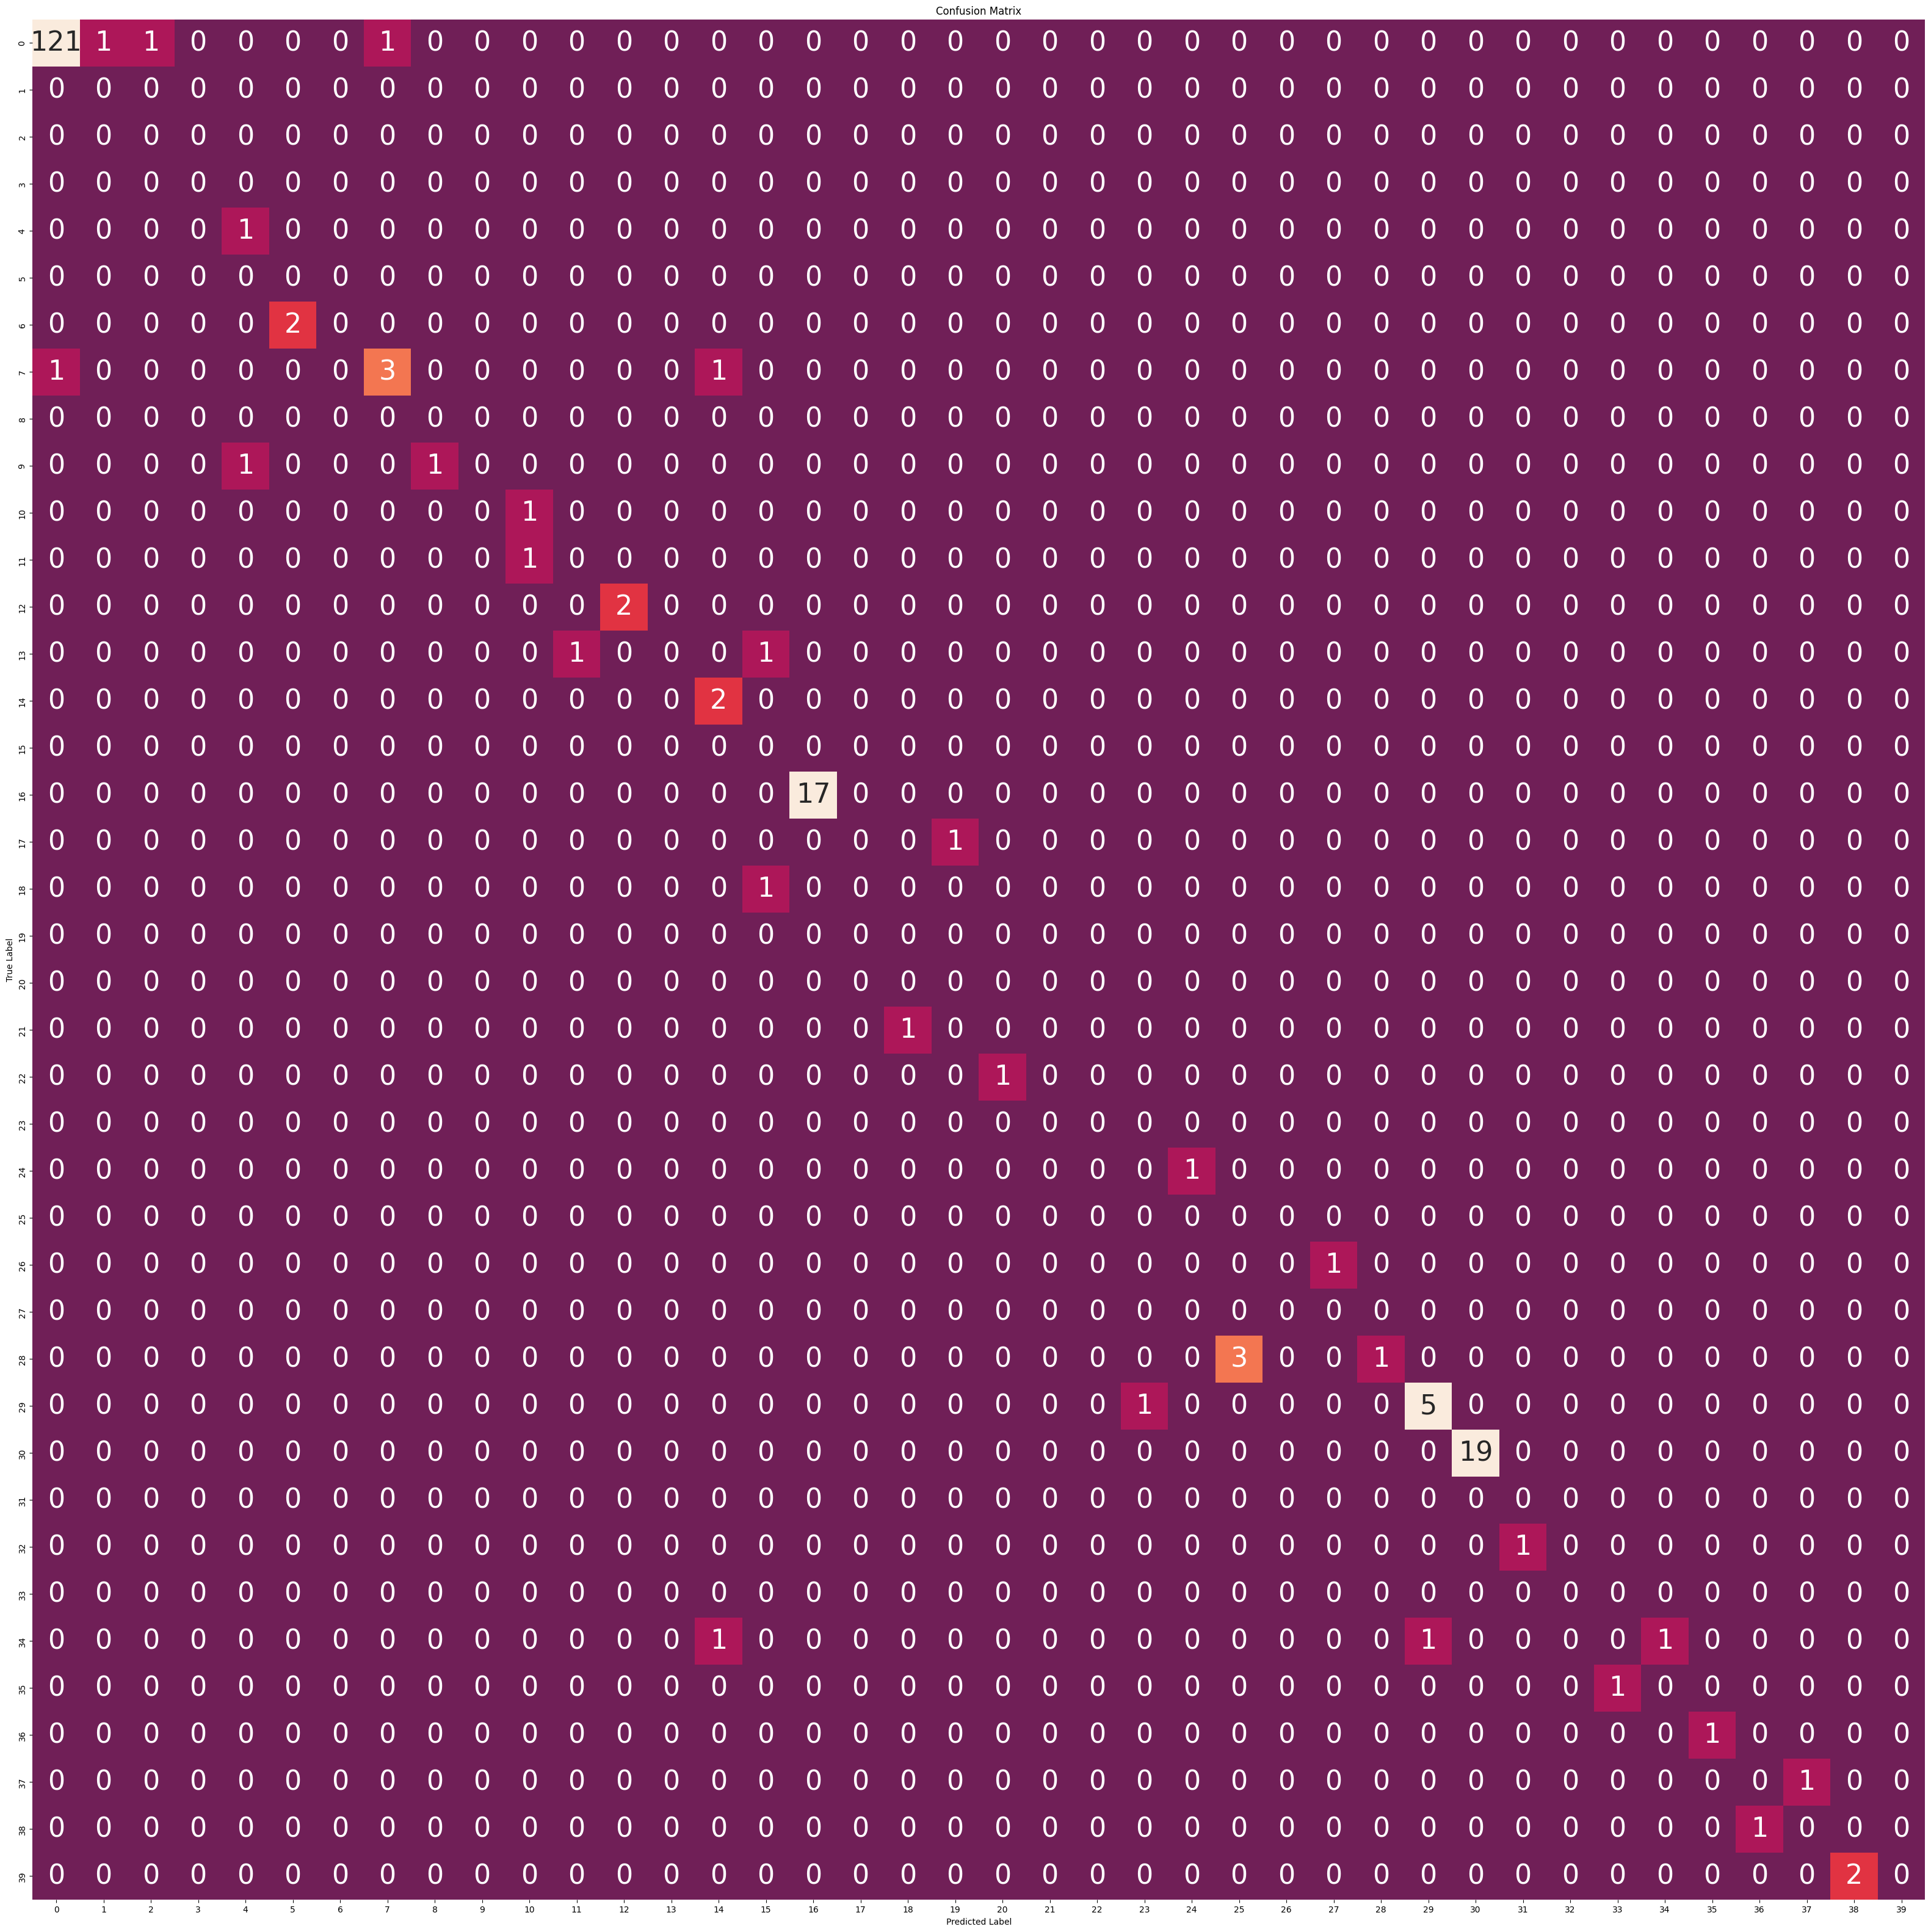

In [33]:
# Plot confusion matrix
plt.figure(figsize=(40, 40))
sns.heatmap(cm[:40,:40], annot=True, fmt='d', vmin=-2, vmax=5, cbar=False,annot_kws={"size":32})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Evaluate Model

In [45]:
# evaluate using similar set with different auralisation
set = 'CH'
instrument = 'AkPnCGdD'
playing_style = 'ST'

eval_ref_pth = os.path.join(datasettoppath,'eval_ref_'+instrument+'_'+set+'_'+playing_style+'.npy')
eval_snp_pth = os.path.join(datasettoppath,'eval_snp_'+instrument+'_'+set+'_'+playing_style+'.npy')
eval_tar_pth = os.path.join(datasettoppath,'eval_tar_'+instrument+'_'+set+'_'+playing_style+'.npy')

eval_ref_pth

'h:\\DL4AD\\Score following\\dl4ad-group5\\data\\MAPS\\eval_ref_AkPnCGdD_CH_ST.npy'

In [ ]:
eval_ref = np.load(eval_ref_pth, mmap_mode='r')
eval_snp = np.load(eval_snp_pth, mmap_mode='r')
eval_tar = np.load(eval_tar_pth, mmap_mode='r')

In [41]:
# from sklearn.metrics import classification_report

# y_test_prob = model.predict([eval_ref,eval_snp],eval_tar[:,0])
# y_test_pred = np.argmax(y_test_prob, axis=1)
#y_test_true = np.argmax(np.array([y for x, y in test_dataset.unbatch().as_numpy_iterator()]), axis=1)


# print('Classification report:')
# print(classification_report( y_pred=y_test_pred, target_names=config['classes'])) # y_true=y_test_true,

# print('------------------------------------------------:')
# print('Evaluate model on test dataset:')
# hist_eval = model.evaluate(test_dataset)

print('------------------------------------------------:')
print('Evaluate model on eval dataset:')
hist_eval = model.evaluate([eval_ref,eval_snp],
                    eval_tar[:,0])

------------------------------------------------:
Evaluate model on eval dataset:
12/12 [==============================] - 1s 35ms/step - loss: 1.4092 - accuracy: 0.6595
